In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# from scipy.misc import imread, imresize

In [2]:
img_size = 335
# Placeholders for input data and the targets
X_input = tf.placeholder(tf.float32, (None, img_size, img_size, 3), name='Input')
X_input_mask = tf.placeholder(tf.float32, (None, img_size, img_size, 1), name='Input_bw')
X_target = tf.placeholder(tf.float32, (None, img_size, img_size, 3), name='Target')

In [3]:
def encoder(z,z_bw, reuse=False):
    """
    Encode part of the autoencoder.
    :param x: input to the autoencoder
    :param reuse: True -> Reuse the encoder variables, False -> Create or search of variables before creating
    :return: tensor which is the hidden latent variable of the autoencoder.
    """
    if reuse:
        tf.get_variable_scope().reuse_variables()
    with tf.name_scope('Encoder'):
        filters = {1:2,2:1,3:3, 4:40, 5:50, 6:60}
        conv1 = tf.layers.conv2d(z, filters[1], (3,3),strides=(1, 1), padding='valid',activation=tf.nn.relu, use_bias=True, kernel_initializer='random_uniform', bias_initializer=tf.zeros_initializer())
        conv2 = tf.layers.conv2d(z_bw, filters[2], (3,3),strides=(1,1),padding='valid',activation=tf.nn.relu,use_bias=True, kernel_initializer='random_uniform', bias_initializer=tf.zeros_initializer())
        conv3 = tf.layers.conv2d(conv1, filters[1], (3,3),strides=(1,1),padding='valid',activation=tf.nn.relu,use_bias=True, kernel_initializer='random_uniform', bias_initializer=tf.zeros_initializer())
        conv4 = tf.layers.conv2d(conv2, filters[2], (3,3),strides=(1,1),padding='valid',activation=tf.nn.relu,use_bias=True, kernel_initializer='random_uniform', bias_initializer=tf.zeros_initializer())
        
        conv = tf.concat([conv3, conv4], 3)
        #conv_shortcut = conv
        conv5 = tf.layers.conv2d(conv, filters[3],(3,3), strides=(1, 1), padding='valid', activation=tf.nn.relu,use_bias=True, kernel_initializer='random_uniform', bias_initializer=tf.zeros_initializer())
        print('conv1',np.shape(conv1))
        print('conv2',np.shape(conv2))
        print('conv3',np.shape(conv3))
        print('conv4',np.shape(conv4))
        print('conv5',np.shape(conv5))
        lv = tf.contrib.layers.flatten(conv5)
        
    return conv5, lv, lv.get_shape()

In [4]:
# conv = encoder(X_input, X_input_mask)

In [ ]:
class vgg16_1:
    def __init__(self, imgs, weights=None, sess=None):
        self.imgs = imgs
        self.convlayers()
#         self.fc_layers()
        self.map = self.pool5
#         self.probs = tf.nn.softmax(self.fc3l)
        if weights is not None and sess is not None:
            self.load_weights(weights, sess)


    def convlayers(self):
        self.parameters = []

        # zero-mean input
        with tf.name_scope('preprocess') as scope:
            mean = tf.constant([123.68, 116.779, 103.939], dtype=tf.float32, shape=[1, 1, 1, 3], name='img_mean')
            images = self.imgs-mean

        # conv1_1
        with tf.name_scope('conv1_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 3, 64], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(images, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv1_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv1_2
        with tf.name_scope('conv1_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 64, 64], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv1_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv1_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool1
        self.pool1 = tf.nn.max_pool(self.conv1_2,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool1')

        # conv2_1
        with tf.name_scope('conv2_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 64, 128], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[128], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv2_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv2_2
        with tf.name_scope('conv2_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 128, 128], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv2_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[128], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv2_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool2
        self.pool2 = tf.nn.max_pool(self.conv2_2,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool2')

        # conv3_1
        with tf.name_scope('conv3_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 128, 256], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv3_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv3_2
        with tf.name_scope('conv3_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 256], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv3_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv3_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv3_3
        with tf.name_scope('conv3_3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 256], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv3_2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv3_3 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool3
        self.pool3 = tf.nn.max_pool(self.conv3_3,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool3')

        # conv4_1
        with tf.name_scope('conv4_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool3, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv4_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv4_2
        with tf.name_scope('conv4_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv4_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv4_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv4_3
        with tf.name_scope('conv4_3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv4_2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv4_3 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool4
        self.pool4 = tf.nn.max_pool(self.conv4_3,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool4')

        # conv5_1
        with tf.name_scope('conv5_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool4, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv5_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv5_2
        with tf.name_scope('conv5_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv5_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv5_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv5_3
        with tf.name_scope('conv5_3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv5_2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv5_3 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool5
        self.pool5 = tf.nn.max_pool(self.conv5_3,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool4')

#     def fc_layers(self):
#         # fc1
#         with tf.name_scope('fc1') as scope:
#             shape = int(np.prod(self.pool5.get_shape()[1:]))
#             fc1w = tf.Variable(tf.truncated_normal([shape, 4096],
#                                                          dtype=tf.float32,
#                                                          stddev=1e-1), name='weights')
#             fc1b = tf.Variable(tf.constant(1.0, shape=[4096], dtype=tf.float32),
#                                  trainable=True, name='biases')
#             pool5_flat = tf.reshape(self.pool5, [-1, shape])
#             fc1l = tf.nn.bias_add(tf.matmul(pool5_flat, fc1w), fc1b)
#             self.fc1 = tf.nn.relu(fc1l)
#             self.parameters += [fc1w, fc1b]

#         # fc2
#         with tf.name_scope('fc2') as scope:
#             fc2w = tf.Variable(tf.truncated_normal([4096, 4096],
#                                                          dtype=tf.float32,
#                                                          stddev=1e-1), name='weights')
#             fc2b = tf.Variable(tf.constant(1.0, shape=[4096], dtype=tf.float32),
#                                  trainable=True, name='biases')
#             fc2l = tf.nn.bias_add(tf.matmul(self.fc1, fc2w), fc2b)
#             self.fc2 = tf.nn.relu(fc2l)
#             self.parameters += [fc2w, fc2b]

#         # fc3
#         with tf.name_scope('fc3') as scope:
#             fc3w = tf.Variable(tf.truncated_normal([4096, 1000],
#                                                          dtype=tf.float32,
#                                                          stddev=1e-1), name='weights')
#             fc3b = tf.Variable(tf.constant(1.0, shape=[1000], dtype=tf.float32),
#                                  trainable=True, name='biases')
#             self.fc3l = tf.nn.bias_add(tf.matmul(self.fc2, fc3w), fc3b)
#             self.parameters += [fc3w, fc3b]

    def load_weights(self, weight_file, sess):
        weights = np.load(weight_file)
        keys = sorted(weights.keys())
        for i, k in enumerate(keys):
            print(i, k, np.shape(weights[k]))
            sess.run(self.parameters[i].assign(weights[k]))

In [5]:
class vgg16_2:
    def __init__(self, imgs, weights=None, sess=None):
        self.imgs = imgs
        self.convlayers()
#         self.fc_layers()
        self.map = self.pool5
#         self.probs = tf.nn.softmax(self.fc3l)
        if weights is not None and sess is not None:
            self.load_weights(weights, sess)


    def convlayers(self):
        self.parameters = []

        # zero-mean input
        with tf.name_scope('preprocess') as scope:
            mean = tf.constant([123.68, 116.779, 103.939], dtype=tf.float32, shape=[1, 1, 1, 3], name='img_mean')
            images = self.imgs-mean

        # conv1_1
        with tf.name_scope('conv1_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 3, 64], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(images, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv1_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv1_2
        with tf.name_scope('conv1_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 64, 64], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv1_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv1_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool1
        self.pool1 = tf.nn.max_pool(self.conv1_2,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool1')

        # conv2_1
        with tf.name_scope('conv2_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 64, 128], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[128], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv2_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv2_2
        with tf.name_scope('conv2_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 128, 128], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv2_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[128], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv2_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool2
        self.pool2 = tf.nn.max_pool(self.conv2_2,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool2')

        # conv3_1
        with tf.name_scope('conv3_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 128, 256], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv3_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv3_2
        with tf.name_scope('conv3_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 256], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv3_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv3_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv3_3
        with tf.name_scope('conv3_3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 256], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv3_2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv3_3 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool3
        self.pool3 = tf.nn.max_pool(self.conv3_3,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool3')

        # conv4_1
        with tf.name_scope('conv4_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool3, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv4_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv4_2
        with tf.name_scope('conv4_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv4_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv4_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv4_3
        with tf.name_scope('conv4_3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv4_2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv4_3 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool4
        self.pool4 = tf.nn.max_pool(self.conv4_3,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool4')

        # conv5_1
        with tf.name_scope('conv5_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool4, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv5_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv5_2
        with tf.name_scope('conv5_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv5_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv5_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv5_3
        with tf.name_scope('conv5_3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv5_2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv5_3 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool5
        self.pool5 = tf.nn.max_pool(self.conv5_3,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool4')

#     def fc_layers(self):
#         # fc1
#         with tf.name_scope('fc1') as scope:
#             shape = int(np.prod(self.pool5.get_shape()[1:]))
#             fc1w = tf.Variable(tf.truncated_normal([shape, 4096],
#                                                          dtype=tf.float32,
#                                                          stddev=1e-1), name='weights')
#             fc1b = tf.Variable(tf.constant(1.0, shape=[4096], dtype=tf.float32),
#                                  trainable=True, name='biases')
#             pool5_flat = tf.reshape(self.pool5, [-1, shape])
#             fc1l = tf.nn.bias_add(tf.matmul(pool5_flat, fc1w), fc1b)
#             self.fc1 = tf.nn.relu(fc1l)
#             self.parameters += [fc1w, fc1b]

#         # fc2
#         with tf.name_scope('fc2') as scope:
#             fc2w = tf.Variable(tf.truncated_normal([4096, 4096],
#                                                          dtype=tf.float32,
#                                                          stddev=1e-1), name='weights')
#             fc2b = tf.Variable(tf.constant(1.0, shape=[4096], dtype=tf.float32),
#                                  trainable=True, name='biases')
#             fc2l = tf.nn.bias_add(tf.matmul(self.fc1, fc2w), fc2b)
#             self.fc2 = tf.nn.relu(fc2l)
#             self.parameters += [fc2w, fc2b]

#         # fc3
#         with tf.name_scope('fc3') as scope:
#             fc3w = tf.Variable(tf.truncated_normal([4096, 1000],
#                                                          dtype=tf.float32,
#                                                          stddev=1e-1), name='weights')
#             fc3b = tf.Variable(tf.constant(1.0, shape=[1000], dtype=tf.float32),
#                                  trainable=True, name='biases')
#             self.fc3l = tf.nn.bias_add(tf.matmul(self.fc2, fc3w), fc3b)
#             self.parameters += [fc3w, fc3b]

    def load_weights(self, weight_file, sess):
        weights = np.load(weight_file)
        keys = sorted(weights.keys())
        for i, k in enumerate(keys):
            print(i, k, np.shape(weights[k]))
            sess.run(self.parameters[i].assign(weights[k]))

In [6]:
#function for deconv
def decode(x):
    act = tf.nn.relu(x)
    upsample1 = tf.image.resize_nearest_neighbor(act, (512,512))
    conv5 = tf.layers.conv2d(upsample1, 40, (7,7), padding='same',activation=tf.nn.relu)
    upsample2 = tf.image.resize_nearest_neighbor(conv5, (636,636))
    conv6 = tf.layers.conv2d(upsample2, 20, (5,5), padding='same',activation=tf.nn.relu)
    upsample3 = tf.image.resize_nearest_neighbor(conv6, (776,776))
    conv7 = tf.layers.conv2d(upsample3, 3, (7,7), padding='same',activation=tf.nn.relu)
    upsample4 = tf.image.resize_nearest_neighbor(conv7, (1024,1024))
    output = tf.layers.conv2d(upsample4, 3, (7,7), padding='same',activation=tf.nn.relu)

    return output

C:\Users\VergilCrimson\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


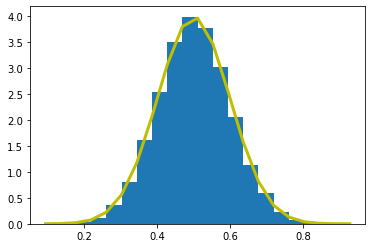

In [7]:
def make_normal_distribution(input_shape):
    mu, sigma = 0.0, 1.0
    norm_dist = np.random.normal(mean, sigma, input_shape)
    count, bins, ignored = plt.hist(norm_dist, 20, normed=True)
    return norm_dist
# # Plot the distribution curve
# plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
#     np.exp( - (bins - mu)**2 / (2 * sigma**2) ),       linewidth=3, color='y')
# plt.show()

In [7]:
def gram_matrix(input_tensor):
    # if input tensor is a 3D array of size Nh x Nw X Nc
    # we reshape it to a 2D array of Nc x (Nh*Nw)
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]

    # get gram matrix 
    gram = tf.matmul(a, a, transpose_a=True)

    return gram

def get_style_loss(base_style, gram_target):
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)
    # Original eqn as a constant to divide i.e 1/(4. * (channels ** 2) * (width * height) ** 2)
    return tf.reduce_mean(tf.square(gram_style - gram_target)) / (channels**2 * width * height) #(4.0 * (channels ** 2) * (width * height) ** 2)

In [8]:
#reconstruction loss
def reconstruction_loss(x_target, reconstructed_image):
    lr=0.001
    L2_loss = tf.reduce_mean(tf.square(x_target - reconstructed_image))
    style_loss = get_style_loss(reconstructed_image, x_target)
    reconstruction_loss = L2_loss + style_loss
    reconstruction_optimizer = tf.train.AdamOptimizer(learning_rate=lr,
                                                       beta1=0.9).minimize(reconstruction_loss)
    return reconstruction_loss, reconstruction_optimizer

#KL divergence loss
def KLdivergence_loss(encode_LD, groundtruth_LD, normal_dist):
    k = tf.keras.losses.KLDivergence()
    kl_loss = k(encode_LD, groundtruth_LD) + k(encode_LD, normal_dist) + k(groundtruth_LD, normal_dist)
    return kl_loss

#wgan loss
def wgan_loss(d_real, d_fake):
    lr=0.01
    disc_loss = tf.reduce_mean(d_real)-tf.reduce_mean(d_fake)
    discriminator_optimizer = tf.train.RMSPropOptimizer(learning_rate=lr).minimize(-disc_loss)
    return disc_loss, discriminator_optimizer

In [9]:
if __name__ == '__main__':
#     sess = tf.Session()
#     conv, ld = encoder(X_input, X_input_mask)
    vgg1 = vgg16_1(X_input, 'vgg16_weights.npz', None)
    vgg2 = vgg16_2(X_input_mask, 'vgg16_weights.npz', None)
    conv, ld, ld_shape = encoder(vgg1.pool5, vgg2.pool5)
    
    reconstructed_image = decode(conv)
    norm_D = make_normal_distribution(ld_shape)
    reconst_loss, reconst_opt = reconstruction_loss(X_target, reconstructed_image)
    kl_loss = KLdivergence_loss(ld, gt_LD, norm_D)
    disc_loss, disc_opt = wgan_loss(X_target, reconstructed_image)
    
    batch_size=62
    epochs=100
    init=tf.global_variables_initializer()
    samples_n=[] 
    minibatch_loss_n = 0
    cost_n=[]
    with tf.Session() as sess:
        sess.run(init)
        for epoch in tqdm(range(epochs)):
            num_batches=56
            for i in range(num_batches):
#                 X, X_bw, X_mask = datafornoisyimages(i)
#                 Y, _ = datafornoisyimages(i)
                _, temp_loss = sess.run([reconst_opt,reconst_loss], feed_dict={x_input:X, x_input_bw:X_bw, x_input_mask:X_mask, x_target:Y})
                _, temp_loss = sess.run([disc_opt,disc_loss], feed_dict={x_input:X, x_input_bw:X_bw, x_input_mask:X_mask})
                minibatch_loss_n += temp_loss / num_batches

            print("on epoch{}".format(epoch))
            # Print the cost every epoch
            print ("Cost after epoch %i: %f" % (epoch, minibatch_loss_n))
            cost_n.append(minibatch_loss_n)
        
#     img1 = imread('laska.png', mode='RGB')
#     img1 = imresize(img1, (224, 224))

#     prob = sess.run(vgg.probs, feed_dict={vgg.imgs: [img1]})[0]
#     preds = (np.argsort(prob)[::-1])[0:5]
#     for p in preds:
#         print class_names[p], prob[p]

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `layer.__call__` method instead.
conv1 (?, 333, 333, 2)
conv2 (?, 333, 333, 1)
conv3 (?, 331, 331, 2)
conv4 (?, 331, 331, 1)
conv5 (?, 329, 329, 3)
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.


ValueError: Dimensions must be equal, but are 335 and 1024 for 'sub' (op: 'Sub') with input shapes: [?,335,335,3], [?,1024,1024,3].